In [10]:
import sys
sys.path.append('~/.local/lib/python2.7/site-packages/dwave')
#sys.path.append('~/.local/bin')

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from dwave.system.composites import TilingComposite
from dimod import SampleSet,BQM, ExactSolver
import dimod

from orang import OrangSampler

import numpy as np

from importlib import reload

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
linear = {0:0, 1:0}
quadratic = {(0,1): -1}
bqm = BQM(linear, quadratic, 0, 'SPIN')

linear2 = {0:0, 1:0, 2:0, 3:0}
quadratic2 = {(0,1): -1, (2,3): -1}
bqm2 = BQM(linear2, quadratic2, 0, 'SPIN')

linear3 = {0:0, 1:0, 2:0, 3:0}
quadratic3 = {(0,1): -1, (2,3): -1, (0,3):-1, (1,2):-1}
bqm3 = BQM(linear3, quadratic3, 0, 'SPIN')

In [12]:
dwsamp = EmbeddingComposite(DWaveSampler())
num_samples = 1000

In [13]:
r = dwsamp.sample(bqm2, num_reads=num_samples)

In [14]:
r.first

Sample(sample={0: 1, 1: 1, 2: 1, 3: 1}, energy=-2.0, num_occurrences=268, chain_break_fraction=0.0)

In [15]:
r

SampleSet(rec.array([([ 1,  1,  1,  1], -2., 268, 0.),
           ([-1, -1, -1, -1], -2., 236, 0.),
           ([-1, -1,  1,  1], -2., 282, 0.),
           ([ 1,  1, -1, -1], -2., 214, 0.)],
          dtype=[('sample', 'i1', (4,)), ('energy', '<f8'), ('num_occurrences', '<i8'), ('chain_break_fraction', '<f8')]), [0, 1, 2, 3], {'timing': {'qpu_sampling_time': 163960, 'qpu_anneal_time_per_sample': 20, 'qpu_readout_time_per_sample': 123, 'qpu_access_time': 171499, 'qpu_access_overhead_time': 1256, 'qpu_programming_time': 7539, 'qpu_delay_time_per_sample': 21, 'total_post_processing_time': 305, 'post_processing_overhead_time': 305, 'total_real_time': 171499, 'run_time_chip': 163960, 'anneal_time_per_run': 20, 'readout_time_per_run': 123}}, 'SPIN')

In [16]:
def update_bqm(old_bqm, beta_nudge):
    linear = {u: beta_nudge * bias for u, bias in old_bqm.linear.items()}
    quadratic = {(u,v): beta_nudge * bias for (u,v), bias in old_bqm.quadratic.items()}
    return dimod.BQM(linear, quadratic, offset=0, vartype=dimod.SPIN)


def compute_energy_stats(rec):
    """

    Args:
        rec: SampleSet.record recarray

    Returns:
        mean energy, standard deviation, standard error
    """
    mean_energy = np.sum(rec.energy * rec.num_occurrences) / rec.num_occurrences.sum()
#     mean_energy = energies.mean()
    var_energies = np.sum(rec.energy - mean_energy) / rec.num_occurrences.sum()
    stderr_energies = np.sqrt(var_energies) / np.sqrt(rec.num_occurrences.sum())
    return mean_energy, var_energies, stderr_energies

In [17]:
compute_energy_stats(r.record)

(-2.0, 0.0, 0.0)

In [18]:
orang_sampler = OrangSampler()

learning_rate = 0.1

qpu_mean_en, qpu_var_en, pu_stderr_en = compute_energy_stats(r.record)

print 
betas = [1]
for i in range(num_samples):
    
    if (i+1) % int(num_samples/100) == 0:
        learning_rate -= 0.005 #Does this need adjusting???
        print(learning_rate)
    
    new_bqm = update_bqm(bqm2, betas[-1])

    resp = orang_sampler.sample(new_bqm, num_reads=num_samples)

#     print(f'Orang energies = {resp.record.energy[:5]}')

    mean_en, var_en, stderr_en = compute_energy_stats(resp.record)

#     print("qpu_mean - mean = {}".format(qpu_mean_en - mean_en))

#     print(f'delta term = {(learning_rate / max(1, var_en)) * (qpu_mean_en - mean_en)}')
#     beta1 = betas[-1] - (learning_rate / max(1, var_en)) * np.sign(qpu_mean_en - mean_en)
    beta2 = betas[-1] - (learning_rate / max(1, var_en)) * (qpu_mean_en - mean_en)

    betas.append(beta2)

#     print("BETA", betas[-1])


/home/csel-ima2019-31/.ima-wave/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


0.095
0.09
0.08499999999999999
0.07999999999999999
0.07499999999999998
0.06999999999999998
0.06499999999999997
0.05999999999999998
0.05499999999999998
0.04999999999999998
0.044999999999999984
0.03999999999999999
0.03499999999999999
0.02999999999999999
0.024999999999999988
0.019999999999999987
0.014999999999999986
0.009999999999999985
0.0049999999999999845
-1.5612511283791264e-17
-0.005000000000000016
-0.010000000000000016
-0.015000000000000017
-0.020000000000000018
-0.02500000000000002
-0.03000000000000002
-0.03500000000000002
-0.040000000000000015
-0.04500000000000001
-0.05000000000000001
-0.05500000000000001
-0.060000000000000005
-0.065
-0.07
-0.07500000000000001
-0.08000000000000002
-0.08500000000000002
-0.09000000000000002
-0.09500000000000003
-0.10000000000000003
-0.10500000000000004
-0.11000000000000004
-0.11500000000000005
-0.12000000000000005
-0.12500000000000006
-0.13000000000000006
-0.13500000000000006
-0.14000000000000007
-0.14500000000000007
-0.15000000000000008
-0.15500000

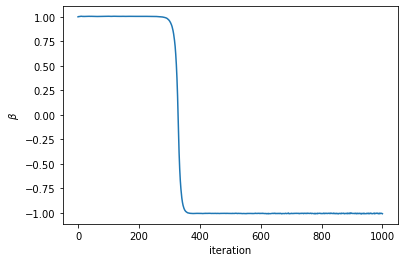

In [19]:
ax = plt.figure().gca()
ax.plot(betas)
ax.set_xlabel('iteration')
ax.set_ylabel(r'$\beta$')

print()

In [92]:
np.mean(betas)

1.0

new_bqm